In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import os
from datetime import datetime
import math
import lifelines

In [2]:
data_path = r"C:\Users\mgaut\Documents\Info_Vis_Project\mimic-iii-clinical-database-demo-1.4"
paths = [i.split(".") for i in os.listdir(data_path)]
f_paths = list(filter(lambda x: x[1]=='csv', paths))
d_paths = [".".join(path) for path in f_paths]
d_paths = [os.path.join(data_path, i) for i in d_paths]
names = [i for i, j in f_paths]
data = {}
for name, path in zip(names, d_paths):
    data[name] = pd.read_csv(path)


C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8,10,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (17,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.keys()

dict_keys(['ADMISSIONS', 'CALLOUT', 'CAREGIVERS', 'CHARTEVENTS', 'CPTEVENTS', 'DATETIMEEVENTS', 'DIAGNOSES_ICD', 'DRGCODES', 'D_CPT', 'D_ICD_DIAGNOSES', 'D_ICD_PROCEDURES', 'D_ITEMS', 'D_LABITEMS', 'ICUSTAYS', 'INPUTEVENTS_CV', 'INPUTEVENTS_MV', 'LABEVENTS', 'MICROBIOLOGYEVENTS', 'NOTEEVENTS', 'OUTPUTEVENTS', 'PATIENTS', 'PRESCRIPTIONS', 'PROCEDUREEVENTS_MV', 'PROCEDURES_ICD', 'SERVICES', 'TRANSFERS'])

In [4]:
items = data['D_ITEMS']
items = items[items.linksto=='chartevents']
chart_items = pd.merge(data['CHARTEVENTS'], items, on = 'itemid')

In [5]:
admit = data['ADMISSIONS']
died = admit[admit.discharge_location == 'DEAD/EXPIRED']
d_locs = set(admit.discharge_location.to_list())
survive = admit[admit.discharge_location!='DEAD/EXPIRED']

In [6]:
died_admit_location = died.groupby('admission_location').count().sort_values(by='row_id', ascending = False)
surv_admit_location = survive.groupby('admission_location').count().sort_values(by='row_id', ascending = False)
all_admit_location = admit.groupby('admission_location').count().sort_values(by='row_id', ascending = False)
died_admit_location

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
admission_location,,,,,,,,,,,,,,,,,,
EMERGENCY ROOM ADMIT,26,26,26,26,26,26,26,26,26,13,25,17,26,26,26,26,26,26
TRANSFER FROM HOSP/EXTRAM,11,11,11,11,11,11,11,11,11,6,11,10,11,1,1,11,11,11
PHYS REFERRAL/NORMAL DELI,2,2,2,2,2,2,2,2,2,1,2,2,2,0,0,2,2,2
CLINIC REFERRAL/PREMATURE,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1


In [7]:
drg_desc = data['DRGCODES'].groupby('description').count().sort_values(by='row_id', ascending=False).reset_index()
drg_codes = data['DRGCODES']
died_drg = pd.merge(died, drg_codes, on = 'hadm_id')
died_drg = died_drg.groupby('description').count().sort_values(by='row_id_x', ascending=False).reset_index()

In [8]:
# top_drg_desc['label'] = top_drg_desc['description'].apply(lambda x: x[0:25])
# top_drg_desc = top_drg_desc.assign(
#     label = lambda data: data['description'].map(lambda x: x[0:25])
# )

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


<Figure size 432x288 with 0 Axes>

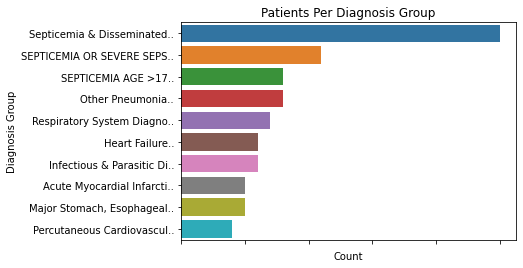

<Figure size 432x288 with 0 Axes>

In [9]:
data['PATIENTS']
top_drg_desc = drg_desc.head(10)
top_drg_desc = top_drg_desc.assign(
    label = lambda data: data['description'].map(lambda x: x[0:25] + "..")
)
ax = sns.barplot(top_drg_desc.row_id, top_drg_desc.label, orient='h')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel = "Count", ylabel = "Diagnosis Group", title = "Patients Per Diagnosis Group")
plt.figure()

In [10]:
def convert_datetime(string):
    date = datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
    return date

In [11]:
patient_admit = pd.merge(died, data['PATIENTS'], on='subject_id')
time_vars = ['admittime', 'deathtime', 'dob', 'dod']
# patient_admit['admittime'] = patient_admit['admittime'].map(convert_datetime)
# patient_admit['deathtime'] = patient_admit['deathtime'].map(convert_datetime)
# patient_admit['dob'] = patient_admit['dob'].map(convert_datetime)

for var in time_vars:
    patient_admit[var] = patient_admit[var].map(convert_datetime)
    patient_admit[var] = patient_admit[var].map(lambda x: x.to_pydatetime())
    
patient_admit['span'] = list(map(lambda x, y: y-x, patient_admit.admittime,patient_admit.deathtime))
patient_admit['span'] = patient_admit.span.dt.days

birth = patient_admit.dob.to_list()
death = patient_admit.dod.to_list()
births = [day.to_pydatetime() for day in birth]
deaths = [day.to_pydatetime() for day in death]
age = [d-b for b,d in zip(births, deaths)]
ages = [int(a.days/365) for a in age]
patient_admit['age'] = ages

patient_admit = patient_admit[patient_admit.age <100]
patient_admit['age_group'] = patient_admit['age'].map(lambda x: str(math.floor(x/10)*10) + 's')

avg_span_age = patient_admit.groupby('age_group', as_index=False)['span'].mean()


C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 0, 'Age Group'),
 Text(0, 0.5, 'Days'),
 Text(0.5, 1.0, 'Days Survived in ICU of Deceased Patients by Age')]

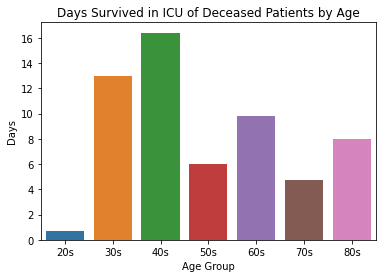

In [12]:
avg_span_age
ax = sns.barplot(avg_span_age.age_group, avg_span_age.span)
ax.set(xlabel="Age Group", ylabel="Days", title="Days Survived in ICU of Deceased Patients by Age")

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='age', ylabel='span'>

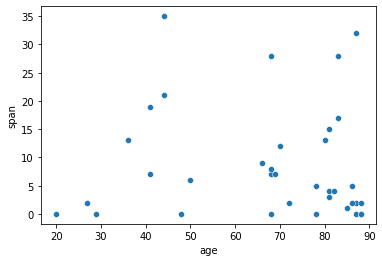

In [13]:
# patient_admit
sns.scatterplot(patient_admit.age, patient_admit.span)


In [14]:
# chart_items
# data['PATIENTS']
patient_chart_items = pd.merge(patient_admit, chart_items, on="subject_id")
# patient_chart_items = patient_chart_items[patient_chart_items.dbsource=='metavision']
patient_chart_items['charttime'] = patient_chart_items['charttime'].map(convert_datetime)
most_recent = patient_chart_items.groupby('subject_id', as_index=False)['charttime'].max()
recent_pat_chart = pd.merge(most_recent, patient_chart_items, on = ['subject_id', 'charttime'])

In [15]:
chart_group = patient_chart_items.groupby('category', as_index=False).count().sort_values(by='subject_id', ascending=False)
chart_group.head(10)

,category,row_id_x_x,subject_id,hadm_id_x,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,...,resultstatus,stopped,row_id_y_y,label,abbreviation,dbsource,linksto,unitname,param_type,conceptid
23,Respiratory,25081,25081,25081,25081,25081,25081,25081,25081,25081,...,0,0,25081,25081,25081,25081,25081,16334,25081,0
25,Routine Vital Signs,22343,22343,22343,22343,22343,22343,22343,22343,22343,...,0,0,22343,22343,22343,22343,22343,14602,22343,0
20,Neurological,19005,19005,19005,19005,19005,19005,19005,19005,19005,...,0,0,19005,19005,19005,19005,19005,0,19005,0
24,Restraint/Support Systems,16954,16954,16954,16954,16954,16954,16954,16954,16954,...,0,0,16954,16954,16954,16954,16954,0,16954,0
29,Treatments,13177,13177,13177,13177,13177,13177,13177,13177,13177,...,0,0,13177,13177,13177,13177,13177,0,13177,0
14,GI/GU,9428,9428,9428,9428,9428,9428,9428,9428,9428,...,0,0,9428,9428,9428,9428,9428,4,9428,0
27,Skin - Impairment,7449,7449,7449,7449,7449,7449,7449,7449,7449,...,0,0,7449,7449,7449,7449,7449,893,7449,0
21,Pain/Sedation,6812,6812,6812,6812,6812,6812,6812,6812,6812,...,0,0,6812,6812,6812,6812,6812,0,6812,0
6,Alarms,6394,6394,6394,6394,6394,6394,6394,6394,6394,...,0,0,6394,6394,6394,6394,6394,4443,6394,0
10,Chemistry,6374,6374,6374,6374,6374,6374,6374,6374,6374,...,6373,6373,6374,6374,0,6374,6374,0,0,0


In [19]:
patient_admit

,row_id_x,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,row_id_y,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,span,age,age_group
0,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,...,9472,F,2090-06-05,2126-08-28,2126-08-28 00:00:00,NaN,1,13,36,30s
1,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,9474,F,2038-09-03,2125-10-07,2125-10-07 00:00:00,2125-10-07 00:00:00,1,2,87,80s
2,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,9479,M,2114-06-20,2163-05-15,2163-05-15 00:00:00,2163-05-15 00:00:00,1,0,48,40s
4,12295,10045,126949,2129-11-24 00:31:00,2129-12-01 01:45:00,2129-12-01 01:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,9504,F,2061-03-25,2129-12-01,2129-12-01 00:00:00,2129-12-01 00:00:00,1,7,68,60s
5,12309,10059,122098,2150-08-22 17:33:00,2150-08-29 18:20:00,2150-08-29 18:20:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,9517,M,2081-01-03,2150-08-29,2150-08-29 00:00:00,2150-08-29 00:00:00,1,7,69,60s
6,12314,10064,111761,2127-03-19 14:39:00,2127-03-19 18:09:00,2127-03-19 18:09:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,9522,M,2058-04-23,2127-03-19,2127-03-19 00:00:00,NaN,1,0,68,60s
7,12317,10067,160442,2130-10-06 01:34:00,2130-10-06 02:29:00,2130-10-06 02:29:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,...,9525,M,2101-06-10,2130-10-06,2130-10-06 00:00:00,NaN,1,0,29,20s
8,12319,10069,146672,2188-02-08 11:15:00,2188-02-27 18:41:00,2188-02-27 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,...,9527,F,2146-10-23,2188-02-27,2188-02-27 00:00:00,2188-02-27 00:00:00,1,19,41,40s
9,12326,10076,198503,2107-03-21 21:16:00,2107-03-30 12:00:00,2107-03-30 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,9533,M,2038-05-10,2107-03-30,2107-03-30 00:00:00,2107-03-30 00:00:00,1,8,68,60s
10,12340,10089,190301,2132-08-05 18:48:00,2132-08-08 02:15:00,2132-08-08 02:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,9545,M,2046-04-18,2132-08-08,2132-08-08 00:00:00,2132-08-08 00:00:00,1,2,86,80s
